link to the colab notebook <br>https://colab.research.google.com/drive/14rwsy0zHusT3JLIi5VhvV1XRbbzEBTxv?usp=sharing

# Task 3 — Visualizing Model Attention with Grad-CAM

In this task, we use **Grad-CAM (Gradient-weighted Class Activation Mapping)** to understand *where* the CNN focuses when making predictions.

This helps us determine whether the model is looking at:
- Meaningful digit strokes (shape-based reasoning), or
- Background/color regions (shortcut learning)

We apply this to both the **biased training set** and the **hard test set**.


In [1]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR


In [2]:
import torch
import random

digit_colors = {
    0: torch.tensor([1.0, 0.2, 0.2]),
    1: torch.tensor([0.2, 1.0, 0.2]),
    2: torch.tensor([0.2, 0.2, 1.0]),
    3: torch.tensor([1.0, 1.0, 0.2]),
    4: torch.tensor([1.0, 0.2, 1.0]),
    5: torch.tensor([0.2, 1.0, 1.0]),
    6: torch.tensor([1.0, 0.5, 0.2]),
    7: torch.tensor([0.6, 0.2, 1.0]),
    8: torch.tensor([0.2, 0.7, 0.7]),
    9: torch.tensor([1.0, 0.4, 0.7]),
}
swapped_colors = {i: digit_colors[(i + 1) % 10] for i in range(10)}
class BiasedTexturedMNIST:
    def __init__(self, bias_prob=0.95,is_hard=False):
        self.bias_prob = bias_prob
        self.is_hard_set = is_hard

    def __call__(self, img, label,rng):
        img = img.squeeze(0)  # [28,28] grayscale
        img = img.clamp(0,1)

        # Digit mask
        digit_mask = img > 0.2
        bg_mask = ~digit_mask
        if self.is_hard_set:
            if torch.rand(1, generator=rng).item() < self.bias_prob:
              base_color =  digit_colors[label]
            else:
              base_color = swapped_colors[label]
        else:
          # Choose dominant or random color
          if torch.rand(1, generator=rng).item() < self.bias_prob:
              base_color = digit_colors[label]
          else:
              base_color = torch.rand(3, generator=rng)

        base_color = base_color.view(3,1,1)

        # ---------- FOREGROUND (digit stroke) ----------
        grayscale = img.unsqueeze(0)                 # keep MNIST intensity
        fg_color = base_color * grayscale            # color tied to shape
        fg_texture = torch.randn(3,28,28,generator=rng) * 0.08     # subtle texture
        foreground = foreground = 0.8 * fg_color + 0.2 * grayscale.repeat(3,1,1) + fg_texture


        # ---------- BACKGROUND ----------
        bg_texture = torch.randn(3,28,28,generator=rng) * 0.05     # very subtle noise
        background = base_color * 0.3 + bg_texture  # faint same hue

        # ---------- COMBINE ----------
        rgb = torch.zeros(3,28,28)
        rgb[:, digit_mask] = foreground[:, digit_mask]
        rgb[:, bg_mask] = background[:, bg_mask]

        return rgb.clamp(0,1)


In [3]:
from torch.utils.data import Dataset

class ColoredMNIST(Dataset):
    def __init__(self, mnist_dataset, bias_prob,is_hard=False):
        self.mnist = mnist_dataset
        self.colorizer = BiasedTexturedMNIST(bias_prob=bias_prob,is_hard=is_hard)

    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, idx):
        rng = torch.Generator()
        rng.manual_seed(idx)
        img, label = self.mnist[idx]
        img = self.colorizer(img, label,rng)
        return img, label


In [4]:
from torchvision import datasets, transforms

base_train = datasets.MNIST(root="data", train=True, download=True, transform=transforms.ToTensor())
base_test  = datasets.MNIST(root="data", train=False, download=True, transform=transforms.ToTensor())

train_easy = ColoredMNIST(base_train, bias_prob=0.95,is_hard=False)  # strongly biased
test_hard  = ColoredMNIST(base_test,  bias_prob=0.05,is_hard=True)  # mostly wrong colors


100%|██████████| 9.91M/9.91M [00:00<00:00, 122MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 38.0MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 74.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.98MB/s]


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 7, 2, 3)
        self.conv2 = nn.Conv2d(16, 24, 3, 1)

        self.pool = nn.MaxPool2d(2)

        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)

        self.fc1 = nn.Linear(24 * 2 * 2, 32)
        self.fc2 = nn.Linear(32, 10)

        self.gradients = None  # for Grad-CAM

    # Hook to save gradients
    def activations_hook(self, grad):
        self.gradients = grad

    def get_activations_gradient(self):
        return self.gradients

    def get_activations(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        return x  # this is the target layer output

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x.register_hook(self.activations_hook)  # hook here

        x = self.pool(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)


## Upload the weight Task1_v4.pth from github under /Task3/weights

In [6]:
from google.colab import files
uploaded = files.upload()


Saving Task1_v4.pth to Task1_v4.pth


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Net().to(device)

# CHANGE filename if needed
model.load_state_dict(torch.load("Task1_v4.pth", map_location=device))

model.eval()
print("Weights loaded successfully ✅")


Weights loaded successfully ✅


## Grad-CAM Implementation

Grad-CAM highlights image regions that contribute most to the model’s prediction.

Steps:
1. Perform a forward pass to get prediction
2. Compute gradients of the predicted class
3. Weight feature maps using these gradients
4. Upsample the resulting heatmap to image size

The result is a visual explanation of the model's attention.


In [9]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def get_cam(model, input_tensor):
    model.eval()

    # Forward pass
    output = model(input_tensor)
    pred_class = output.argmax(dim=1).item()

    # Backward pass for predicted class
    model.zero_grad()
    output[0, pred_class].backward()

    # Get gradients and activations
    gradients = model.get_activations_gradient()   # [1, C, H, W]
    activations = model.get_activations(input_tensor).detach()

    # Global average pool gradients → weights
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    # Weight the channels
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]

    # Average channels to get heatmap
    heatmap = torch.mean(activations, dim=1).squeeze()

    # ReLU
    heatmap = torch.relu(heatmap)

    # Normalize
    heatmap /= torch.max(heatmap)

    # Resize to image size
    heatmap = F.interpolate(heatmap.unsqueeze(0).unsqueeze(0),
                            size=(28,28),
                            mode='bilinear',
                            align_corners=False)

    heatmap = heatmap.squeeze().cpu().numpy()

    return heatmap, pred_class


In [10]:
img, label = train_easy[100]
input_tensor = img.unsqueeze(0).to(device)

output = model(input_tensor)
pred_class = output.argmax(dim=1).item()

model.zero_grad()
output[0, pred_class].backward()

gradients = model.get_activations_gradient()
activations = model.get_activations(input_tensor).detach()

weights = gradients.mean(dim=(2,3), keepdim=True)
cam = (weights * activations).sum(dim=1)
cam = torch.relu(cam)

cam = F.interpolate(cam.unsqueeze(1), size=(28,28), mode='bilinear', align_corners=False)
cam = cam.squeeze().cpu().numpy()
cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)


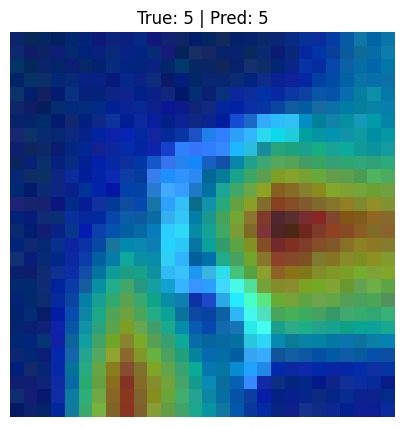

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.imshow(img.permute(1,2,0).cpu())
plt.imshow(cam, cmap='jet', alpha=0.5)
plt.title(f"True: {label} | Pred: {pred_class}")
plt.axis("off")
plt.show()


In [13]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def show_gradcam_grid(model, dataset, device, num_images=100):
    model.eval()

    cols = 10
    rows = num_images // cols

    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    axes = axes.flatten()

    for idx in range(num_images):
        img, label = dataset[idx]
        input_tensor = img.unsqueeze(0).to(device)

        output = model(input_tensor)
        pred_class = output.argmax(dim=1).item()

        model.zero_grad()
        output[0, pred_class].backward()

        gradients = model.get_activations_gradient()
        activations = model.get_activations(input_tensor).detach()

        # Grad-CAM
        weights = gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * activations).sum(dim=1)
        cam = torch.relu(cam)

        cam = F.interpolate(cam.unsqueeze(1), size=(28, 28), mode='bilinear', align_corners=False)
        cam = cam.squeeze().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

        ax = axes[idx]
        ax.imshow(img.permute(1,2,0).cpu())
        ax.imshow(cam, cmap='jet', alpha=0.5)
        ax.set_title(f"T:{label} P:{pred_class}", fontsize=8)
        ax.axis("off")

    plt.tight_layout()
    plt.show()


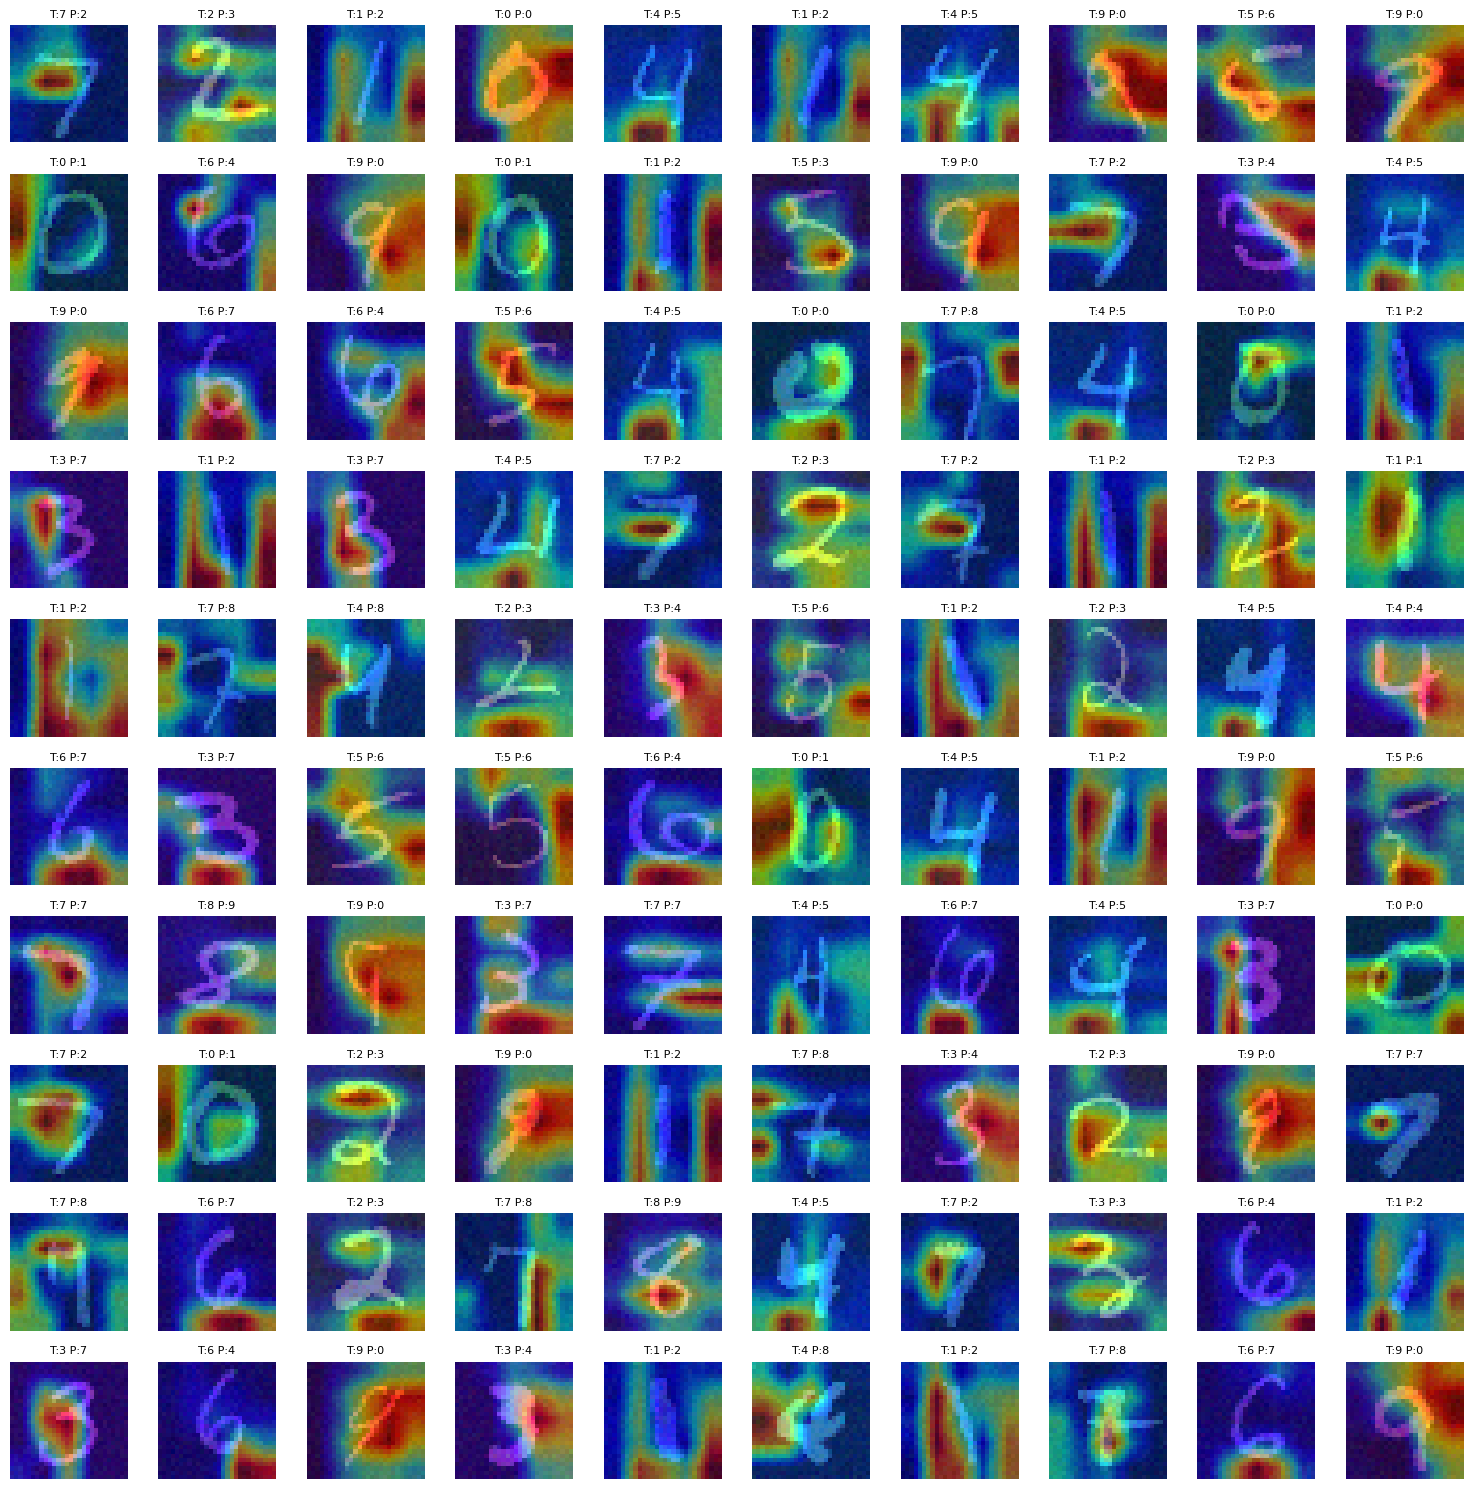

In [14]:
show_gradcam_grid(model, test_hard, device)


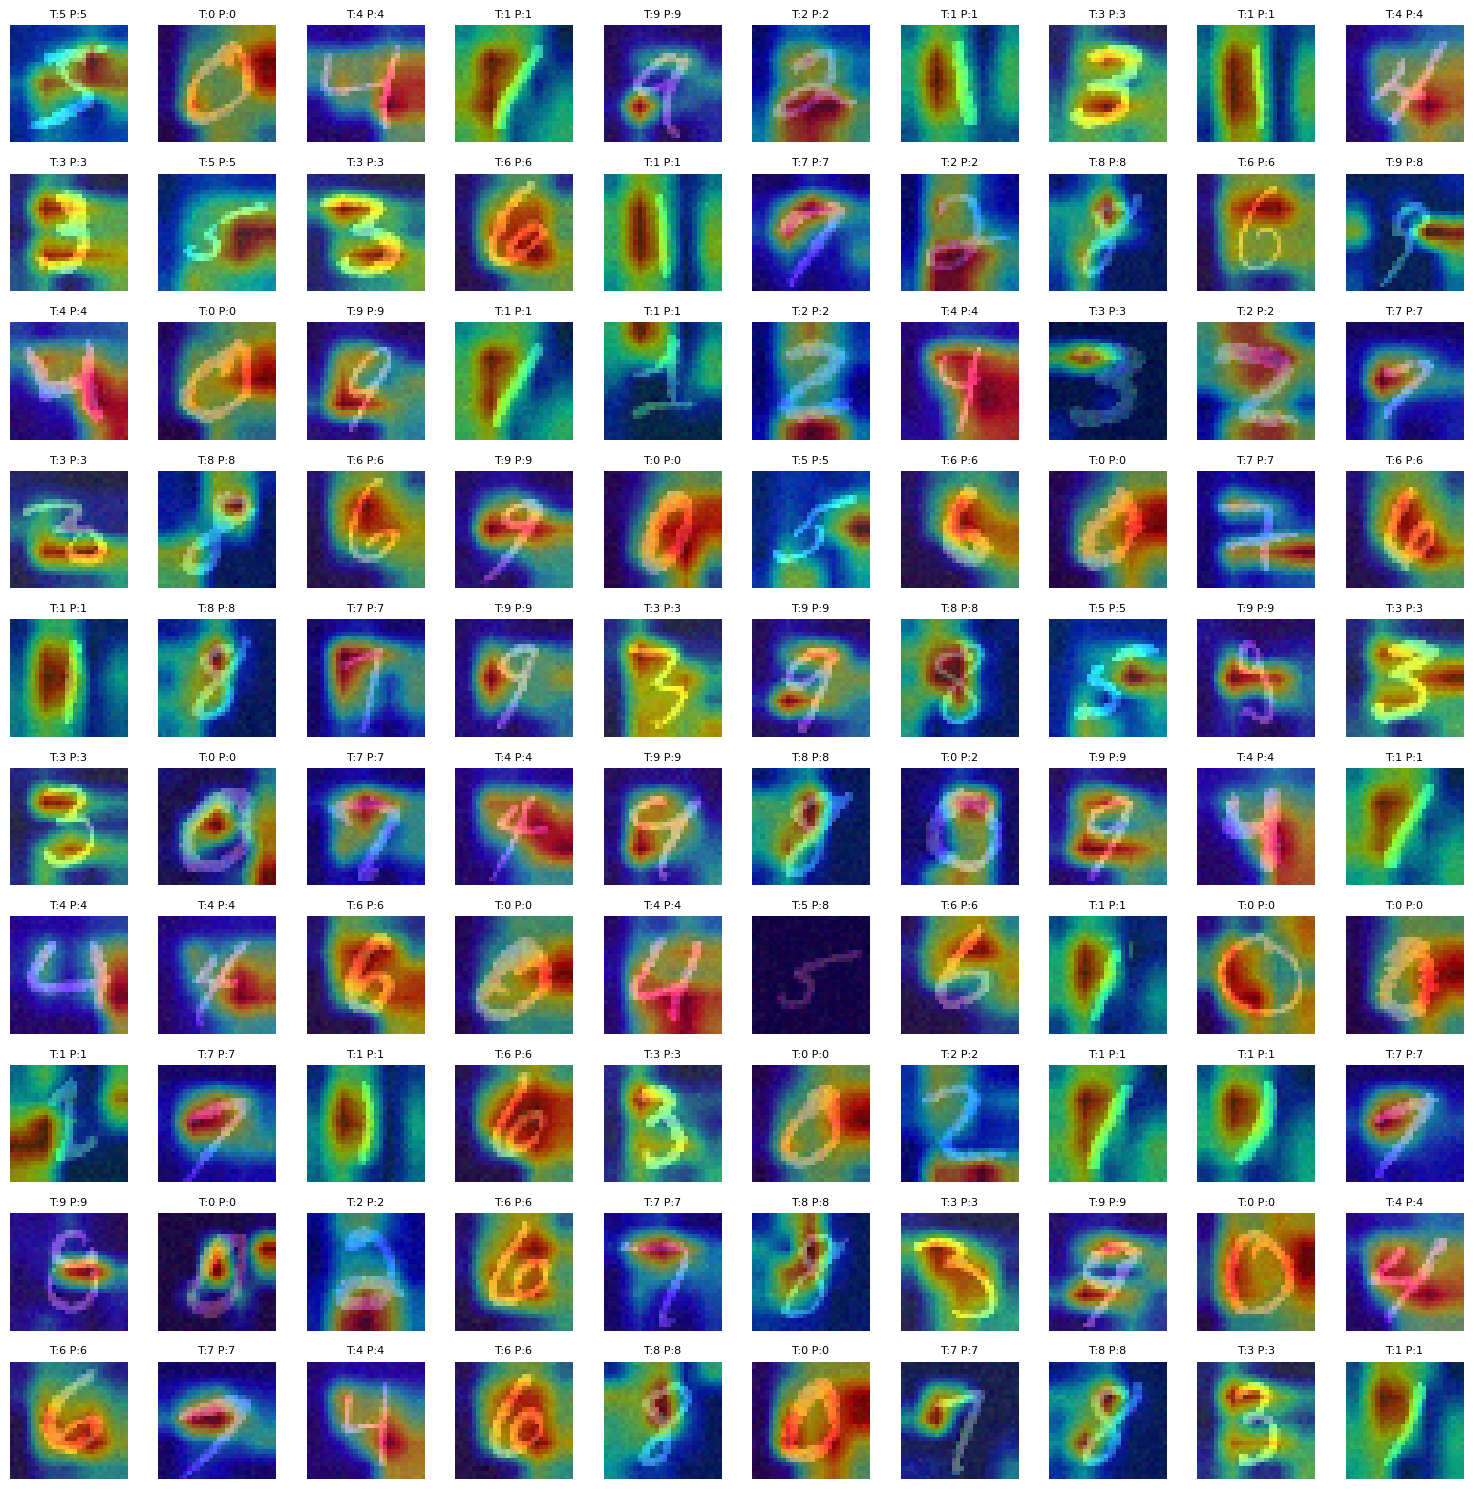

In [15]:
show_gradcam_grid(model, train_easy, device)


## AS we can see here the biased model neurons focused on more spread out or seemingly random regions in the pictures to arrive at a decision showing that they have high colour bias and very little focus on the strokes of the digit